In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime

import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('dataset/train.csv')
test= pd.read_csv('dataset/test.csv')
train.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


In [3]:
train.shape, test.shape

((22083, 45), (9465, 43))

# Exploratory DA

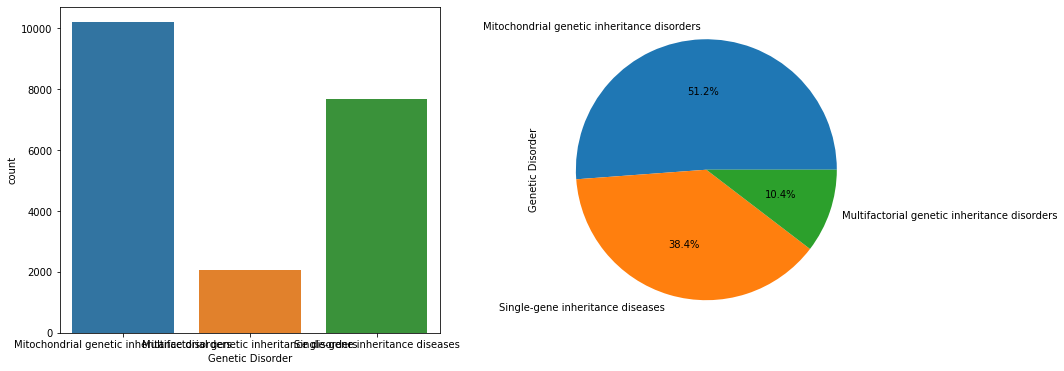

In [6]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='Genetic Disorder', data=train, ax=ax[0])
_ = train['Genetic Disorder'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

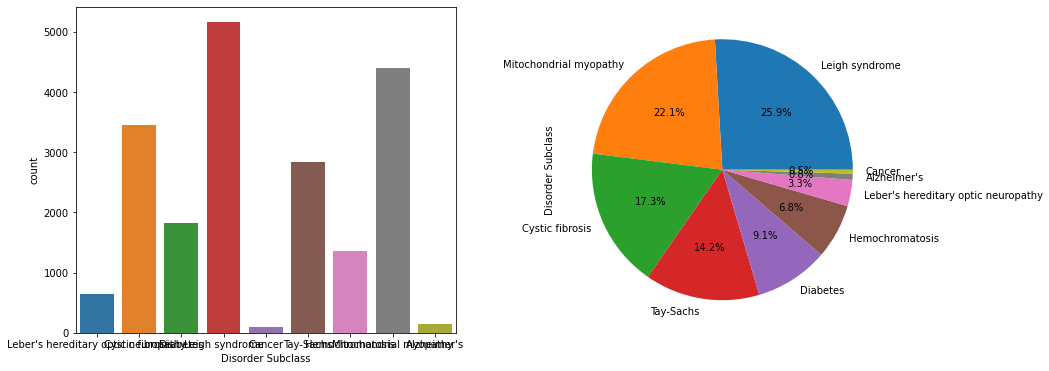

In [8]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='Disorder Subclass', data=train, ax=ax[0])
_ = train['Disorder Subclass'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

In [9]:
train.columns

Index(['Patient Id', 'Patient Age', 'Genes in mother's side',
       'Inherited from father', 'Maternal gene', 'Paternal gene',
       'Blood cell count (mcL)', 'Patient First Name', 'Family Name',
       'Father's name', 'Mother's age', 'Father's age', 'Institute Name',
       'Location of Institute', 'Status', 'Respiratory Rate (breaths/min)',
       'Heart Rate (rates/min', 'Test 1', 'Test 2', 'Test 3', 'Test 4',
       'Test 5', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)', 'Place of birth',
       'Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)',
       'H/O substance abuse', 'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Birth defects',
       'White Blood cell count (thousand per microliter)', 'Blood test result',
       'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'S

In [14]:
X_train = train.drop(columns= ['Genetic Disorder', 'Disorder Subclass', 'Patient Id', 'Patient First Name', 'Family Name', 'Father\'s name',\
                               'Mother\'s age', 'Father\'s age'])
y1 = train['Genetic Disorder']
y2 = train['Disorder Subclass']
X_test = test

0        High
1        High
2         Low
3        High
4         Low
         ... 
22078    High
22079    High
22080    High
22081    High
22082    High
Name: Follow-up, Length: 22083, dtype: object

In [15]:
train.corr()

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
Patient Age,1.000000,0.010819,-0.007588,-0.009797,NaN,NaN,NaN,NaN,NaN,-0.007281,-0.008489,0.003335,0.007506,-0.018755,-0.007470,-0.014463
Blood cell count (mcL),0.010819,1.000000,-0.007163,0.003303,NaN,NaN,NaN,NaN,NaN,-0.005995,-0.001037,0.005793,-0.003913,0.006519,0.005341,0.002281
Mother's age,-0.007588,-0.007163,1.000000,-0.000336,NaN,NaN,NaN,NaN,NaN,0.007844,0.015443,-0.006920,-0.012243,0.008079,-0.009321,0.011743
Father's age,-0.009797,0.003303,-0.000336,1.000000,NaN,NaN,NaN,NaN,NaN,0.000539,0.012954,0.005452,-0.003314,0.012519,-0.001118,0.011630
Test 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No. of previous abortion,-0.007281,-0.005995,0.007844,0.000539,NaN,NaN,NaN,NaN,NaN,1.000000,0.003807,-0.007495,0.007169,-0.000746,0.003735,-0.004264
